# Predicting Car Insurance Cold Call Success
#### Data Source: Public dataset from Kaggle https://www.kaggle.com/kondla/carinsurance
#### Author: Emma Ren
#### Date: July 2017
<br> It shows data exploration and visualization, along with feature engineering and model selection. Any comments/suggestions are welcome.

In [77]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats
from scipy.stats import skew
from scipy.stats import mode
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB

In [49]:
# Read-in train and test datasets
train = pd.read_csv('carInsurance_train.csv')
test = pd.read_csv('carInsurance_test.csv')

In [50]:
print('The train dataset has %d observations and %d features' % (train.shape[0], train.shape[1]))
print('The test dataset has %d observations and %d features' % (test.shape[0], test.shape[1]))

The train dataset has 4000 observations and 19 features
The test dataset has 1000 observations and 19 features


## Data Exploration & Visualization

In [51]:
# Take a peak at the data
train.describe()

,Id,Age,Default,Balance,HHInsurance,CarLoan,LastContactDay,NoOfContacts,DaysPassed,PrevAttempts,CarInsurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,41.214750,0.014500,1532.937250,0.49275,0.133000,15.721250,2.607250,48.706500,0.717500,0.401000
std,1154.844867,11.550194,0.119555,3511.452489,0.50001,0.339617,8.425307,3.064204,106.685385,2.078647,0.490162
min,1.000000,18.000000,0.000000,-3058.000000,0.00000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,111.000000,0.00000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,2000.500000,39.000000,0.000000,551.500000,0.00000,0.000000,16.000000,2.000000,-1.000000,0.000000,0.000000
75%,3000.250000,49.000000,0.000000,1619.000000,1.00000,0.000000,22.000000,3.000000,-1.000000,0.000000,1.000000
max,4000.000000,95.000000,1.000000,98417.000000,1.00000,1.000000,31.000000,43.000000,854.000000,58.000000,1.000000


A cold call success rate of 40%. This is pretty high!

In [52]:
train.describe(include=['O'])

,Job,Marital,Education,Communication,LastContactMonth,Outcome,CallStart,CallEnd
count,3981,4000,3831,3098,4000,958,4000,4000
unique,11,3,3,2,12,3,3777,3764
top,management,married,secondary,cellular,may,failure,17:02:39,10:52:24
freq,893,2304,1988,2831,1049,437,3,3


In [53]:
train.head()

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0


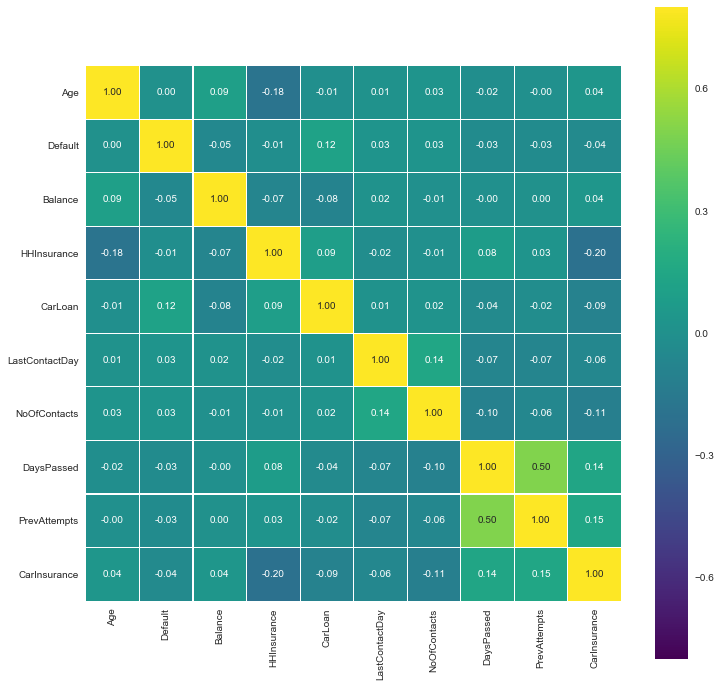

In [54]:
# First check out correlations among numeric features
# Heatmap is a useful tool to get a quick understanding of which variables are important
colormap = plt.cm.viridis
cor = train.corr()
cor = cor.drop(['Id'],axis=1).drop(['Id'],axis=0)
plt.figure(figsize=(12,12))
sns.heatmap(cor,vmax=0.8,cmap=colormap,annot=True,fmt='.2f',square=True,annot_kws={'size':10},linecolor='white',linewidths=0.1)

Features are fairly independent, except DaysPassed and PreAttempts. Cold call success is positively correlated with PreAttemps,DaysPassed,Age and Balance, and negatively correlated with default, HHInsurance, CarLoan, LastContactDay and NoOfContacts.

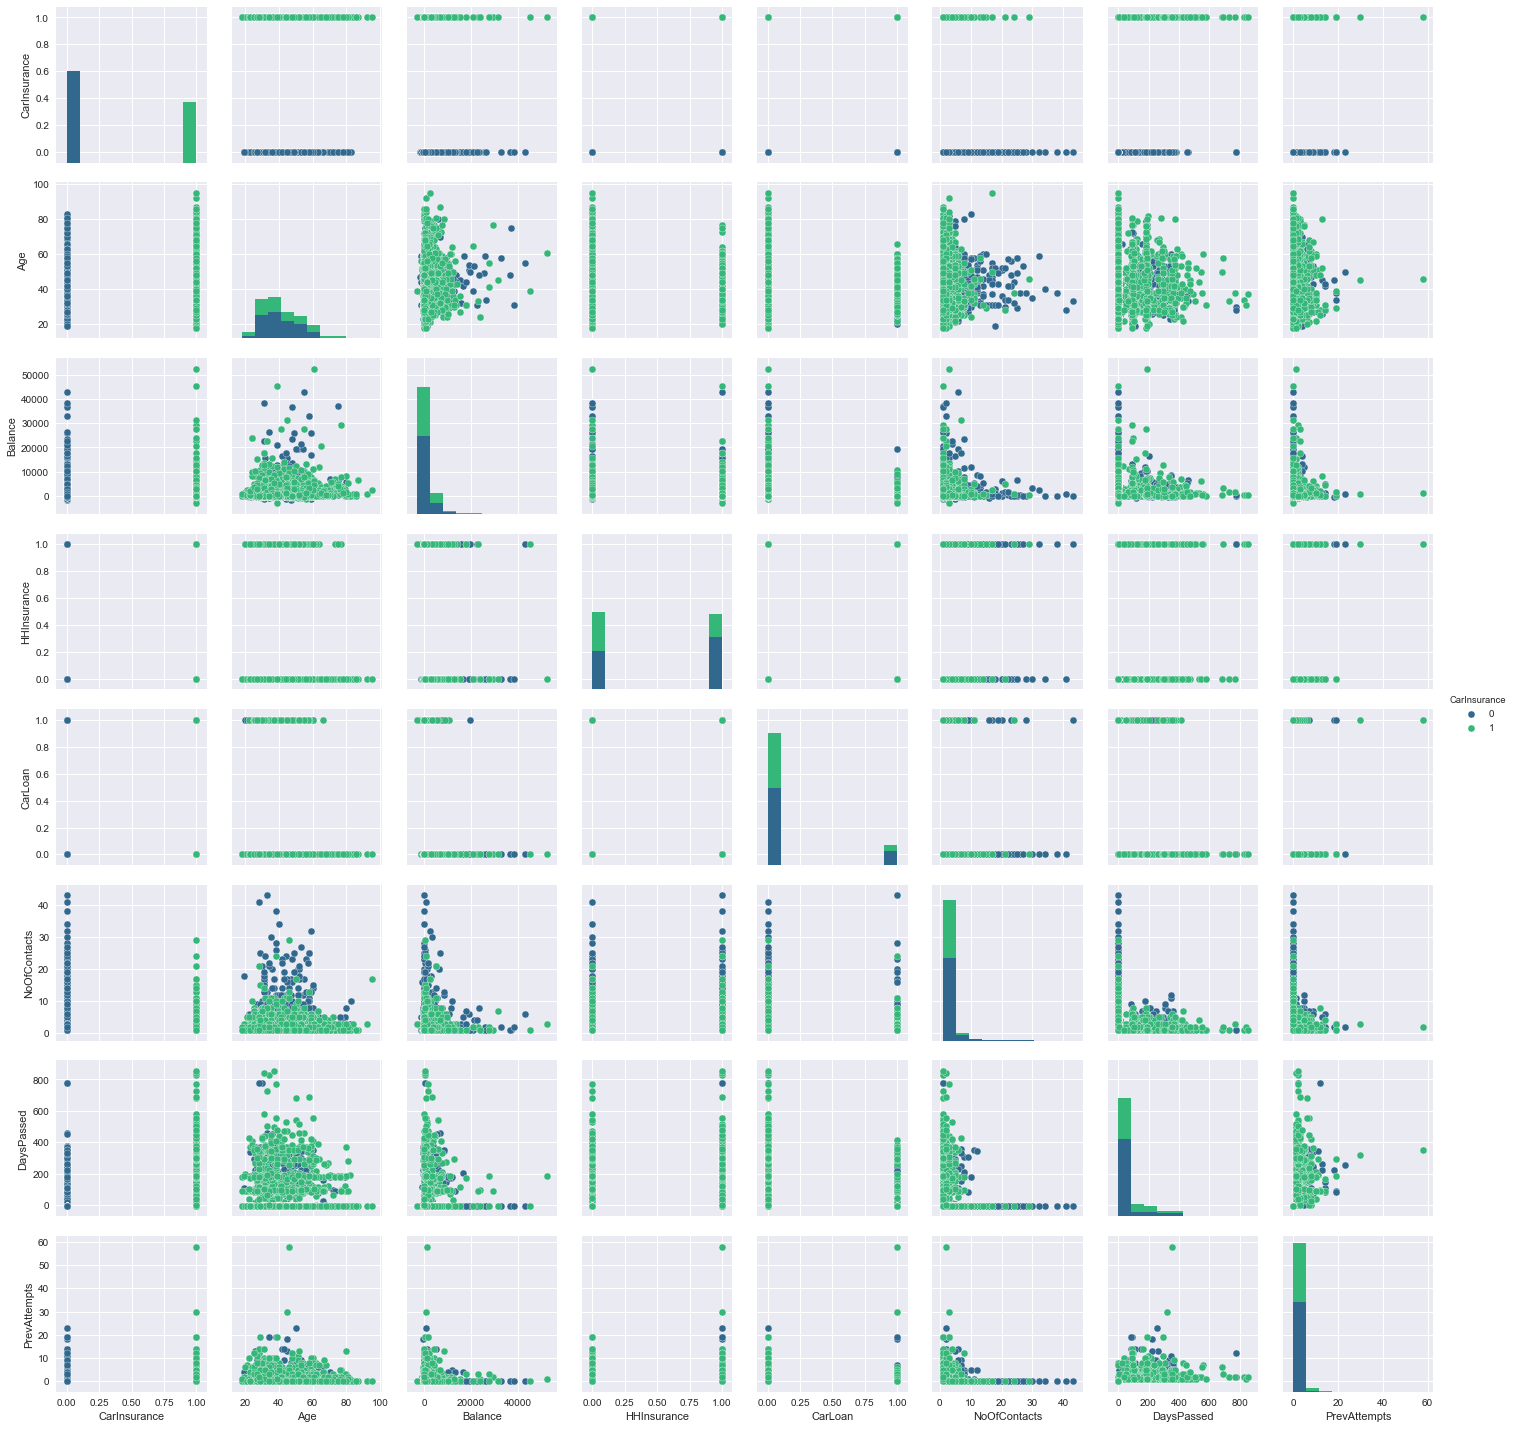

In [85]:
# Next, pair plot some important features
imp_feats = ['CarInsurance','Age','Balance','HHInsurance', 'CarLoan','NoOfContacts','DaysPassed','PrevAttempts']
sns.pairplot(train[imp_feats],hue='CarInsurance',palette='viridis',size=2.5)
plt.show()

<br><b>Age</b>: It's interesting to see that seniors are more likely to buy car insurance. 
<br><b>Balance</b>: For balance, the data point at the upper right corner might be an outlier 
<br><b>HHInsurance</b>: Households insured are less likely to buy car insurance 
<br><b>CarLoan</b>: People with car loan are less likely to buy 
<br><b>NoOfContacts</b>: Too many contacts causes customer attrition
<br><b>DaysPassed</b>: It looks like the more day passed since the last contact, the better
<br><b>PrevAttempts</b>: Also, more previous attempts, less likely to buy. There is a potential outlier here 

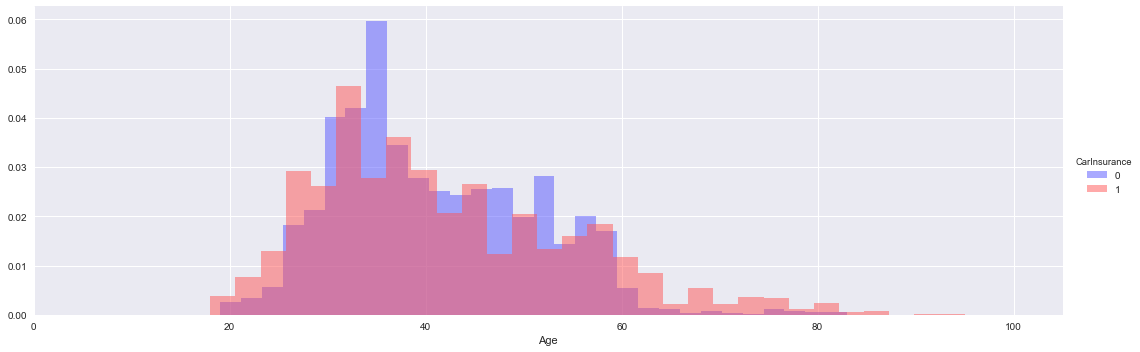

In [57]:
# Take a further look at Age
facet = sns.FacetGrid(train, hue='CarInsurance',size=5,aspect=3,palette='seismic')
facet.map(plt.hist,'Age',bins=30,alpha=0.5,normed=True)
facet.set(xlim=(0,train.Age.max()+10))
facet.add_legend()

It looks like young people(<=30 years) and seniors are more likely to buy car insurance from this bank

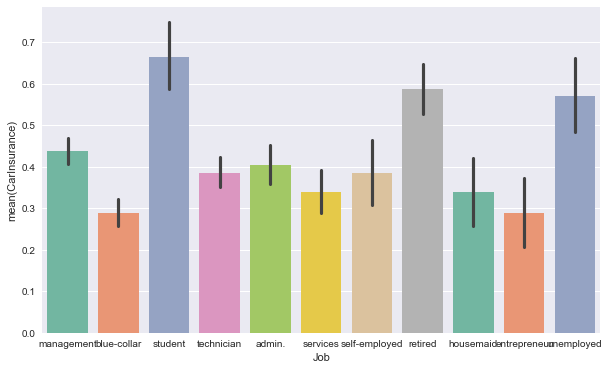

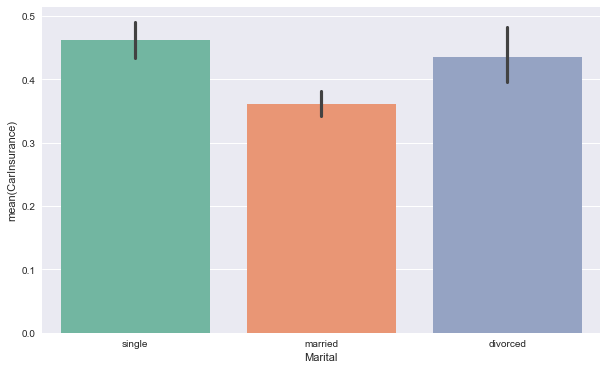

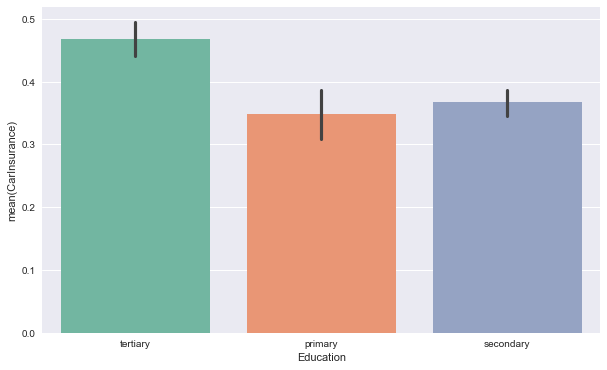

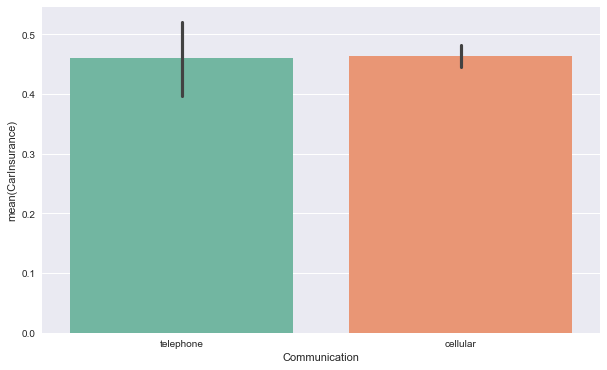

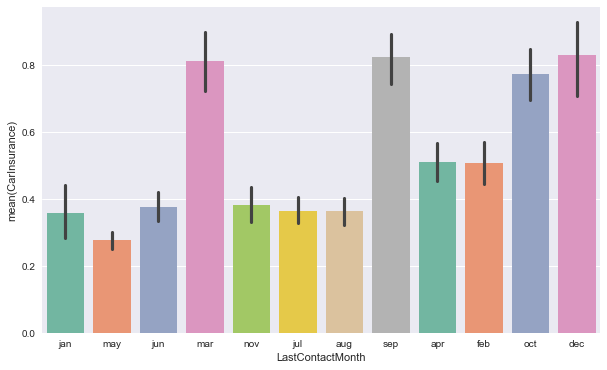

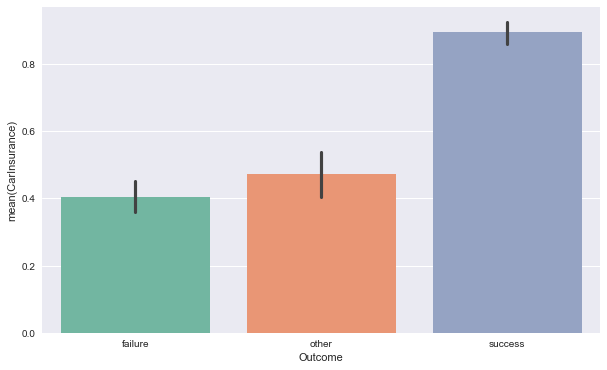

In [56]:
# Next check out categorical features
cat_feats = train.select_dtypes(include=['object']).columns
plt_feats = cat_feats[(cat_feats!= 'CallStart') & (cat_feats!='CallEnd')]

for feature in plt_feats:
    plt.figure(figsize=(10,6))
    sns.barplot(feature,'CarInsurance', data=train,palette='Set2') 


<br> <b>Job</b>: Student are most likely to buy insurance, followed by retired and unemployed folks.This is aligned with the age distribution. There might be some promotion targeting students?
<br> <b>Marital status</b>: Married people are least likely to buy car insurance. Opportunities for developing family insurance business
<br> <b>Education</b>: People with higher education are more likely to buy
<br> <b>Communication</b>: No big difference between cellular and telephone
<br> <b>Outcome in previous campaign</b>: Success in previous marketing campaign is largely associated with success in this campaign
<br> <b>Contact Month</b>: Mar, Sep, Oct, and Dec are the hot months. It might be associated with school season? 

In [102]:
# Check outliers
# From the pairplot, we can see there is an outlier with extreme high balance. Drop that obs here.
train[train['Balance']>80000]
train = train.drop(train[train.index==1742].index)

## Handling Miss Data

In [103]:
# merge train and test data here in order to impute missing values all at once
all=pd.concat([train,test],keys=('train','test'))
all.drop(['CarInsurance','Id'],axis=1,inplace=True)
print(all.shape)

(4999, 17)


In [104]:
total = all.isnull().sum()
pct = total/all.isnull().count()
NAs = pd.concat([total,pct],axis=1,keys=('Total','Pct'))
NAs[NAs.Total>0].sort_values(by='Total',ascending=False)

,Total,Pct
Outcome,3798,0.759752
Communication,1123,0.224645
Education,216,0.043209
Job,24,0.004801


In [105]:
all_df = all.copy()

# Fill missing outcome as not in previous campaign
all_df[all_df['DaysPassed']==-1].count()
all_df.loc[all_df['DaysPassed']==-1,'Outcome']='NoPrev'

# Fill missing communication with none 
all_df['Communication'].value_counts()
all_df['Communication'].fillna('None',inplace=True)

# Fill missing education with the most common education level by job type
all_df['Education'].value_counts()

# Create job-education level mode mapping
edu_mode=[]
job_types = all_df.Job.value_counts().index
for job in job_types:
    mode = all_df[all_df.Job==job]['Education'].value_counts().nlargest(1).index
    edu_mode = np.append(edu_mode,mode)
edu_map=pd.Series(edu_mode,index=all_df.Job.value_counts().index)

# Apply the mapping to missing eductaion obs
for j in job_types:
    all_df.loc[(all_df['Education'].isnull()) & (all_df['Job']==j),'Education'] = edu_map.loc[edu_map.index==j][0]
all_df['Education'].fillna('None',inplace=True)

# Fill missing job with none
all_df['Job'].fillna('None',inplace=True)

# Double check if there is still any missing value
all_df.isnull().sum().sum()

0

## Feature Engineering

<br>There are three types of features:
<br><b>Client features</b>: Age, Job, Marital, Education, Default, Balance, HHInsurance, CarLoan
<br><b>Communication features</b>: LastContactDay, LastContactMonth, CallStart, CallEnd, Communication, NoOfContacts, DaysPassed
<br><b>Previous campaign features</b>: PrevAttempts, Outcome


In [106]:
# First simplify some client features

# Create age group based on age bands
all_df['AgeBand']=pd.cut(all_df['Age'],5)
print(all_df['AgeBand'].value_counts())

all_df.loc[(all_df['Age']>=17) & (all_df['Age']<34),'AgeBin'] = 1
all_df.loc[(all_df['Age']>=34) & (all_df['Age']<49),'AgeBin'] = 2
all_df.loc[(all_df['Age']>=49) & (all_df['Age']<65),'AgeBin'] = 3
all_df.loc[(all_df['Age']>=65) & (all_df['Age']<80),'AgeBin'] = 4
all_df.loc[(all_df['Age']>=80) & (all_df['Age']<96),'AgeBin'] = 5
all_df['AgeBin'] = all_df['AgeBin'].astype(int)

# Create balance groups
all_df['BalanceBand']=pd.cut(all_df['Balance'],5)
print(all_df['BalanceBand'].value_counts())
all_df.loc[(all_df['Balance']>=-3200) & (all_df['Balance']<17237),'BalanceBin'] = 1
all_df.loc[(all_df['Balance']>=17237) & (all_df['Balance']<37532),'BalanceBin'] = 2
all_df.loc[(all_df['Balance']>=37532) & (all_df['Balance']<57827),'BalanceBin'] = 3
all_df.loc[(all_df['Balance']>=57827) & (all_df['Balance']<78122),'BalanceBin'] = 4
all_df.loc[(all_df['Balance']>=78122) & (all_df['Balance']<98418),'BalanceBin'] = 5
all_df['BalanceBin'] = all_df['BalanceBin'].astype(int)

all_df = all_df.drop(['AgeBand','BalanceBand','Age','Balance'],axis=1)

# Convert education level to numeric 
all_df['Education'] = all_df['Education'].replace({'None':0,'primary':1,'secondary':2,'tertiary':3})


(33.4, 48.8]      2184
(17.923, 33.4]    1508
(48.8, 64.2]      1147
(64.2, 79.6]       133
(79.6, 95.0]        27
Name: AgeBand, dtype: int64
(-3113.645, 8071.0]    4847
(8071.0, 19200.0]       123
(19200.0, 30329.0]       20
(30329.0, 41458.0]        5
(41458.0, 52587.0]        4
Name: BalanceBand, dtype: int64


In [107]:
# Next create some new communication Features. This is the place feature engineering coming into play

# Get call length
all_df['CallEnd'] = pd.to_datetime(all_df['CallEnd'])
all_df['CallStart'] = pd.to_datetime(all_df['CallStart'])
all_df['CallLength'] = ((all_df['CallEnd'] - all_df['CallStart'])/np.timedelta64(1,'m')).astype(float)
all_df['CallLenBand']=pd.cut(all_df['CallLength'],5)
print(all_df['CallLenBand'].value_counts())

# Create call length bins
all_df.loc[(all_df['CallLength']>= 0) & (all_df['CallLength']<11),'CallLengthBin'] = 1
all_df.loc[(all_df['CallLength']>=11) & (all_df['CallLength']<22),'CallLengthBin'] = 2
all_df.loc[(all_df['CallLength']>=22) & (all_df['CallLength']<33),'CallLengthBin'] = 3
all_df.loc[(all_df['CallLength']>=33) & (all_df['CallLength']<44),'CallLengthBin'] = 4
all_df.loc[(all_df['CallLength']>=44) & (all_df['CallLength']<55),'CallLengthBin'] = 5
all_df['CallLengthBin'] = all_df['CallLengthBin'].astype(int)
all_df = all_df.drop('CallLenBand',axis=1)

# Get call start hour
all_df['CallStartHour'] = all_df['CallStart'].dt.hour
print(all_df[['CallStart','CallEnd','CallLength','CallStartHour']].head())

# Get workday of last contact based on call day and month, assuming the year is 2016
all_df['LastContactDate'] = all_df.apply(lambda x:datetime.datetime.strptime("%s %s %s" %(2016,x['LastContactMonth'],x['LastContactDay']),"%Y %b %d"),axis=1)
all_df['LastContactWkd'] = all_df['LastContactDate'].dt.weekday
all_df['LastContactWkd'].value_counts()
all_df['LastContactMon'] = all_df['LastContactDate'].dt.month
all_df = all_df.drop('LastContactMonth',axis=1)

# Get week of last contact
all_df['LastContactWk'] = all_df['LastContactDate'].dt.week

# Get num of week in a month. There might be easier ways to do this, I will keep exploring. 
MonWk = all_df.groupby(['LastContactWk','LastContactMon'])['Education'].count().reset_index()
MonWk = MonWk.drop('Education',axis=1)
MonWk['LastContactWkNum']=0
for m in range(1,13):
    k=0
    for i,row in MonWk.iterrows():
        if row['LastContactMon']== m:
            k=k+1
            row['LastContactWkNum']=k
            
def get_num_of_week(df):
    for i,row in MonWk.iterrows():
        if (df['LastContactWk']== row['LastContactWk']) & (df['LastContactMon']== row['LastContactMon']):
            return row['LastContactWkNum']

all_df['LastContactWkNum'] = all_df.apply(lambda x: get_num_of_week(x),axis=1)
print(all_df[['LastContactWkNum','LastContactWk','LastContactMon']].head(10))

(0.0292, 10.91]     4274
(10.91, 21.737]      601
(21.737, 32.563]     104
(32.563, 43.39]       15
(43.39, 54.217]        5
Name: CallLenBand, dtype: int64
                  CallStart             CallEnd  CallLength  CallStartHour
train 0 2017-07-11 13:45:20 2017-07-11 13:46:30    1.166667             13
      1 2017-07-11 14:49:03 2017-07-11 14:52:08    3.083333             14
      2 2017-07-11 16:30:24 2017-07-11 16:36:04    5.666667             16
      3 2017-07-11 12:06:43 2017-07-11 12:20:22   13.650000             12
      4 2017-07-11 14:35:44 2017-07-11 14:38:56    3.200000             14
         LastContactWkNum  LastContactWk  LastContactMon
train 0                 4              4               1
      1                 4             21               5
      2                 1             22               6
      3                 2             19               5
      4                 1             22               6
      5                 3             20           

The two previous campaign features are good to go, no cleaning needed. I also tried to add some interactions and polynomial features, but none of them seems helpful. I am planning to explore more on this.  

## Assembling Final Datasets

In [67]:
# Spilt numeric and categorical features
cat_feats = all_df.select_dtypes(include=['object']).columns
num_feats = all_df.select_dtypes(include=['float64','int64']).columns
num_df = all_df[num_feats]
cat_df = all_df[cat_feats]
print('There are %d numeric features and %d categorical features\n' %(len(num_feats),len(cat_feats)))
print('Numeric features:\n',num_feats.values)
print('Categorical features:\n',cat_feats.values)

There are 17 numeric features and 4 categorical features

Numeric features:
 ['Education' 'Default' 'HHInsurance' 'CarLoan' 'LastContactDay'
 'NoOfContacts' 'DaysPassed' 'PrevAttempts' 'AgeBin' 'BalanceBin'
 'CallLength' 'CallLengthBin' 'CallStartHour' 'LastContactWkd'
 'LastContactMon' 'LastContactWk' 'LastContactWkNum']
Categorical features:
 ['Job' 'Marital' 'Communication' 'Outcome']


In [109]:
# One hot encoding
cat_df = pd.get_dummies(cat_df)

In [110]:
# Merge all features
all_data = pd.concat([num_df,cat_df],axis=1)

In [111]:
# Split train and test
idx=pd.IndexSlice
train_df=all_data.loc[idx[['train',],:]]
test_df=all_data.loc[idx[['test',],:]]
train_label=train['CarInsurance']
print(train_df.shape)
print(len(train_label))
print(test_df.shape)

(3999, 39)
3999
(1000, 39)


In [71]:
# Standardize numeric features
# train_df = StandardScaler().fit_transform(train_df)
# test_df = StandardScaler().fit_transform(test_df)

In [112]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(train_df,train_label,test_size = 0.3,random_state=3)

## Modeling

In [79]:
# Create a cross validation function 
def get_best_model(estimator, params_grid={}):
    
    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(x_train,y_train)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [114]:
# Create a model fitting function
def model_fit(model,feature_imp=True,cv=5):

    # model fit   
    clf = model.fit(x_train,y_train)
    
    # model prediction     
    y_pred = clf.predict(x_test)
    
    # model report     
    cm = confusion_matrix(y_test,y_pred)
    plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

    print('\n--- Train Set -----------------------------')
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv)),np.std(cross_val_score(clf,x_train,y_train,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_train,y_train,cv=cv,scoring='roc_auc'))))
    print('\n--- Validation Set -----------------------------')    
    print('Accuracy: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv)),np.std(cross_val_score(clf,x_test,y_test,cv=cv))))
    print('AUC: %.5f +/- %.4f' % (np.mean(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc')),np.std(cross_val_score(clf,x_test,y_test,cv=cv,scoring='roc_auc'))))
    print('-----------------------------------------------') 

    # feature importance 
    if feature_imp:
        feat_imp = pd.Series(clf.feature_importances_,index=all_data.columns)
        feat_imp = feat_imp.nlargest(15).sort_values()
        plt.figure()
        feat_imp.plot(kind="barh",figsize=(6,8),title="Most Important Features")
  

In [115]:
# The confusion matrix plotting function is from the sklearn documentation below:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = ['Success','Failure']


### k-Nearest Neighbors (KNN)


--- Best Parameters -----------------------------
{'n_neighbors': 6, 'p': 2, 'weights': 'distance'}

--- Best Model -----------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance')

--- Train Set -----------------------------
Accuracy: 0.81854 +/- 0.0222
AUC: 0.88925 +/- 0.0154

--- Validation Set -----------------------------
Accuracy: 0.76491 +/- 0.0254
AUC: 0.84183 +/- 0.0121
-----------------------------------------------


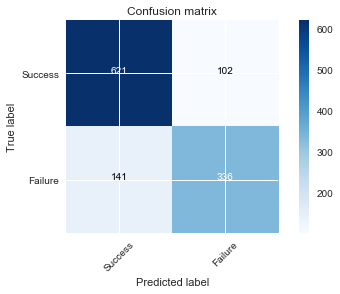

In [118]:
# Let's start with KNN. An accuracy of 0.76 is not very impressive. I will just take this as the model benchmark. 
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[5,6,7], 
              'p':[1,2],
              'weights':['uniform','distance']}
clf_knn = get_best_model(knn,parameters)
model_fit(model=clf_knn, feature_imp=False)

### Naive Bayes Classifier


--- Train Set -----------------------------
Accuracy: 0.75849 +/- 0.0148
AUC: 0.81460 +/- 0.0092

--- Validation Set -----------------------------
Accuracy: 0.73331 +/- 0.0122
AUC: 0.79530 +/- 0.0341
-----------------------------------------------


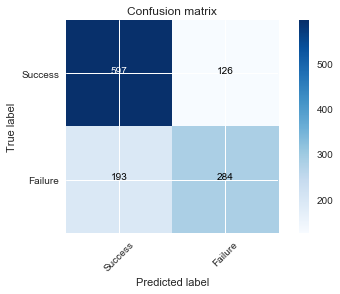

In [119]:
# As expected, Naive Bayes classifier doesn't perform well here. 
# There are multiple reasons. Some of the numeric features are not normally distributed, which is a strong assemption hold by Naive Bayes. 
# Also, features are definitely not independent.  
clf_nb = GaussianNB()
model_fit(model=clf_nb,feature_imp=False)

### Logistic Regression


--- Best Parameters -----------------------------
{'C': 0.9, 'penalty': 'l1'}

--- Best Model -----------------------------
LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=3, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

--- Train Set -----------------------------
Accuracy: 0.81923 +/- 0.0112
AUC: 0.89936 +/- 0.0132

--- Validation Set -----------------------------
Accuracy: 0.80413 +/- 0.0109
AUC: 0.88581 +/- 0.0133
-----------------------------------------------


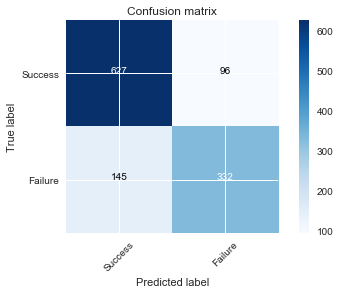

In [120]:
# We're making progress here. Logistic regression performs better than KNN. 
lg = LogisticRegression(random_state=3)
parameters = {'C':[0.8,0.9,1], 
              'penalty':['l1','l2']}
clf_lg = get_best_model(lg,parameters)
model_fit(model=clf_lg, feature_imp=False)

### Random Forest


--- Best Parameters -----------------------------
{'max_depth': 10, 'n_estimators': 100, 'max_features': 13, 'min_samples_split': 11}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=13, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=11, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=3,
            verbose=0, warm_start=False)

--- Train Set -----------------------------
Accuracy: 0.84495 +/- 0.0074
AUC: 0.92308 +/- 0.0078

--- Validation Set -----------------------------
Accuracy: 0.82081 +/- 0.0115
AUC: 0.90453 +/- 0.0081
-----------------------------------------------


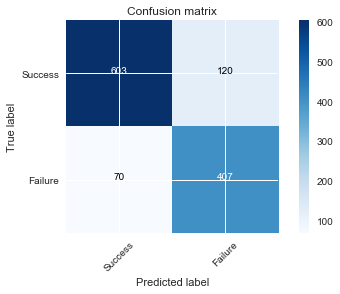

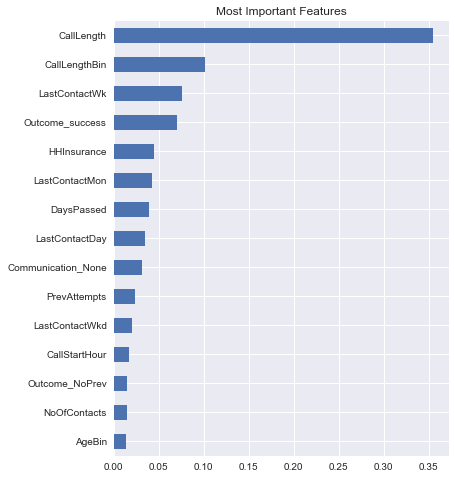

In [122]:
# I did some manual parameter tuning here. This is the best model so far. 
# Based on the feature importance report, call length, last contact week, and previous success are strong predictors of cold call success
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
            'max_depth':[10],
            'max_features':[13,14],
            'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)
model_fit(model=clf_rf, feature_imp=True)

### Support Vector Machines


--- Best Parameters -----------------------------
{'C': 1, 'gamma': 0.01}

--- Best Model -----------------------------
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=3, shrinking=True, tol=0.001,
  verbose=False)

--- Train Set -----------------------------
Accuracy: 0.83569 +/- 0.0215
AUC: 0.90523 +/- 0.0149

--- Validation Set -----------------------------
Accuracy: 0.78242 +/- 0.0253
AUC: 0.86055 +/- 0.0155
-----------------------------------------------


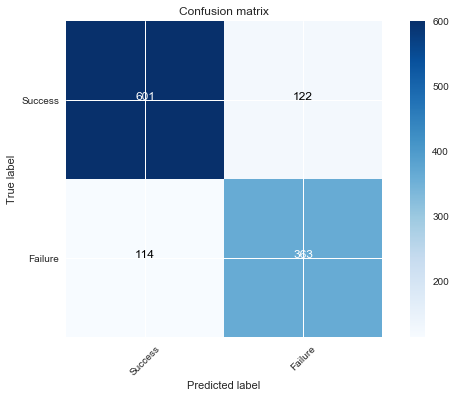

In [32]:
# try a SVM RBF model 
svc = svm.SVC(kernel='rbf', probability=True, random_state=3)
parameters = {'gamma': [0.005,0.01,0.02],
              'C': [0.5,1,5]}
clf_svc = get_best_model(svc, parameters)
model_fit(model=clf_svc,feature_imp=False)

### XGBoost


--- Best Parameters -----------------------------
{'max_depth': 8, 'subsample': 0.8, 'min_child_weight': 1, 'colsample_bytree': 0.4, 'n_estimators': 1000, 'learning_rate': 0.01}

--- Best Model -----------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

--- Train Set -----------------------------
Accuracy: 0.85531 +/- 0.0067
AUC: 0.93441 +/- 0.0063

--- Validation Set -----------------------------
Accuracy: 0.83995 +/- 0.0303
AUC: 0.91564 +/- 0.0134
-----------------------------------------------


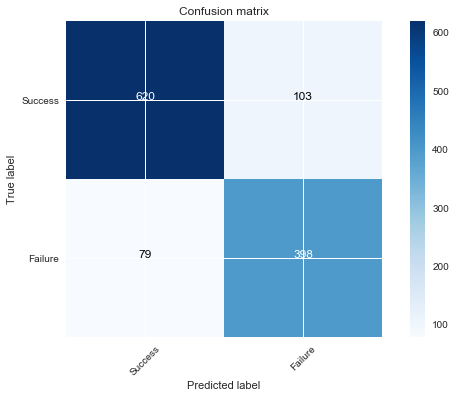

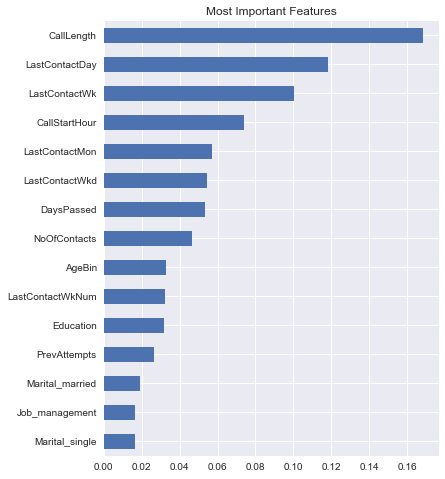

In [39]:
# Finally let's try out XBGoost. As expected, it outperforms all other algorithms. 
# Also, based on feature importances, some of the newly created features such as call start hour, last contact week and weekday 
# have been picked as top features. 

import xgboost as xgb
xgb = xgb.XGBClassifier()
parameters={'n_estimators':[900,1000,1100],
            'learning_rate':[0.01],
            'max_depth':[8],
            'min_child_weight':[1],
            'subsample':[0.8],
            'colsample_bytree':[0.3,0.4,0.5]}
clf_xgb= get_best_model(xgb,parameters)
model_fit(model=clf_xgb, feature_imp=True)

## Model Evaluation

In [123]:
# Compare model performance
clfs= [clf_knn, clf_nb, clf_lg, clf_rf, clf_svc, clf_xgb]
index =['K-Nearest Neighbors','Naive Bayes','Logistic Regression','Random Forest','Support Vector Machines','XGBoost']
scores=[]
for clf in clfs:
    score = np.mean(cross_val_score(clf,x_test,y_test,cv=5,scoring = 'accuracy'))
    scores = np.append(scores,score)
models = pd.Series(scores,index=index)
models.sort_values(ascending=False)

XGBoost                    0.839953
Random Forest              0.820813
Logistic Regression        0.804129
Support Vector Machines    0.782417
K-Nearest Neighbors        0.764906
Naive Bayes                0.733312
dtype: float64

## Ensemble Voting

In [135]:
# XGBoost and Random Forest show different important features, implying that those models are capturing different aspects of the data
# To get the final model, I ensembled different classifiers based on majority voting.
# XGBoost and Random Forest are given larger weights due to their better performance. 

clf_vc = VotingClassifier(estimators=[('xgb', clf_xgb),                                       
                                      ('rf', clf_rf),
                                      ('lg', clf_lg), 
                                      ('svc', clf_svc)], 
                          voting='hard',
                          weights=[4,4,1,1])
clf_vc = clf_vc.fit(x_train, y_train)


In [136]:
print('Final Model Accuracy: %.5f'%(accuracy_score(y_test, clf_vc.predict(x_test))))

Final Model Accuracy: 0.84333


## Next Steps

Here are some thoughts on steps for further improvements:
<br> 1) Do more feature engineering, including exploring interaction and polynomial terms
<br> 2) Visualize decision boundaries for some classifiers
<br> 3) Introduce more base models for learning
<br> 4) Try different ensembling approaches
